# Learning dynamics

[Wolfram Barfuss](https://wbarfuss.github.io) | [University of Bonn](https://www.uni-bonn.de) | 2024/2025 <br>
▶ **Complex Systems Modeling of Human-Environment Interactions**

## Motivation
> Modeling model-based reinforcement learning agents


This chapter introduces **collective reinforcement learning dynamics** - treating the multi-agent reinforcement learning process as a non-linear dynamic system.

### Recap | Reinforcement learning

In chapter [04.02-IndividualLearning](04.02-IndividualLearning.ipynb), we introduced the basics of the temporal-difference reward-prediction reinforcement learning process. In essence, learning means **updating the quality estimates**, $Q^i_t(s,a)$, with the current reward-prediction error, $\delta^i_t(s, a)$, after selection action $a_t$ in state $s_t$ according to

$$
Q^i_{t+1}(s_t, a_t) = Q^i_{t}(s_t, a_t) + \alpha^i \delta^i_t(s_t, a_t),
$$ {#eq-qualityupdate}

where $\alpha^i \in (0,1)$ is the learning rate of agent $i$, which regulates how much new information the agent uses for the update. 

The reward-prediction error, $\delta^i_t(s_t, a_t)$, equals the difference of the **new quality estimate**, $(1-\gamma^i) r^i_t + \gamma^i \mathcal Q_n^i(s_{t+1})$, and the **current quality estimate**, $\mathcal Q_c^i(s_{t})$,

$$
\delta^i_t(s_t, a_t) = (1-\gamma^i) r^i_t + \gamma^i \mathcal{Q}^i_n(s_{t+1}, a_{t+1}) - \mathcal Q^i_c(s_{t}, a_{t}),
$$ {#eq-rewardpredictionerror}

where the $\mathcal{Q}_n^i$ represents the quality estimate of the *next* state and $\mathcal{Q}_c^i$ represents the quality estimate of the *current* state. Depending on how we choose, $\mathcal{Q}_n^i$, and $\mathcal{Q}_c^i$, we recover various well-known temporal-difference reinforcement learning update schemes [@BarfussEtAl2019].

For example, we covered the *Expected SARSA* update with $\mathcal{Q}_n^i (s_{t+1}, a_{t+1})  = \mathcal{Q}_n^i (s_{t+1}) = \sum_b x_t^i(s_{t+1},b) Q^i_t(s_{t+1}, b)$, and $\mathcal{Q}_c^i = Q^i_t$. The temporal-difference reward-prediction error then reads,

$$\delta^i_t(s_t, a_t) = (1-\gamma^i) r^i_t + \gamma^i \sum_b x_t^i(s_{t+1},b) Q^i_t(s_{t+1}, b) - Q^i_t(s_{t}, a_{t}).$$


### Modeling challenges of reinforcement learning
Classic reinforcement learning processes are highly *stochastic* since, generally, all agent strategies $x^i(s, a)$, and the environments transition function $T(s, \boldsymbol a, s')$ are probability distributions. This stochasticity induces some challenges for using reinforcement learning as a modeling tool in complex human-environment systems:


1) **Sample inefficiency.** The agents need many samples to learn something, as they immediately forget a sample experience after a value-belief update.
2) **Computationally intense.** Learning simulations are computationally intense since one requires many simulations to make sense of the noise, and each takes a long time to address the sample inefficiency.
3) **Rare events.** Due to the stochasticity, dealing with rare events is particularly difficult to learn from experience alone.
4) **Hard to explain.** The stochasticity can sometimes make it hard to explain why a phenomenon occurred in a simulation.


In contrast, **human learning is highly efficient.** Thus, as a model of human behavior, this basic reinforcement learning update scheme is implausible:

* Human cognition is not that simplistic, and their actions are not that stochastic.
* Humans typically build and use a model of the world around them.
* Sometimes, it is possible to invest into multiple options at the same time


How can we address these challenges? 

### Dynamics of collective reinforcement learning

The essential idea of the collective reinforcement learning dynamics approach is to **replace** the **individual sample realizations** of the temporal-difference reward-prediction error **with its strategy average** plus a small error term, 

$$\boldsymbol \delta \leftarrow {\boldsymbol\delta_\mathbf{x}} + \boldsymbol\epsilon.$$

Thus, collective reinforcement learning dynamics **describe how agents with access to** (a good approximation of) **the strategy-average reward-prediction error would learn**. 

There are multiple interpretations to motivate how the agents can obtain the strategy averages:

- **Model-based learners**. Agents have a model of how the environment works, including how the other agents behave currently, but not how the other agents learn. The agents use their world model to stabilize learning. In the limit of a perfect model (and sufficient cognitive resources), the error term vanishes, $\boldsymbol\epsilon \rightarrow 0$.
- **Batch learners**. The agents store experiences (state observations, rewards, actions, next state observations) inside a memory batch and replay these experiences to make the learning more stable. Batch learning is a common algorithmic technique in machine learning. In the limit of an infinite memory batch, the error term vanishes, $\boldsymbol\epsilon \rightarrow 0$ [@Barfuss2020].
- **Different timescales**. The agents learn on two different time scales. On one time scale, the agents interact with the environment, collecting experiences and integrating them to improve their quality estimates while keeping their strategies fixed. On the other time scale, they use the accumulated experiences to adapt their strategy. Timescale separation is a common technique used in theoretical physics. In the limit of a complete time scale separation, having infinite experiences between two strategy updates, the error term vanishes, $\boldsymbol\epsilon \rightarrow 0$ [@Barfuss2022].
- **Proportional investors**. Instead of choosing actions individually, agents can invest an endowment into actions proportional to their policy. Assuming by analogy, that the environment is not in one of its states but described by its state distribution, agents receive feedback proportionally to their investment. When there is no noise in the rewards itself, the error term vanishes, $\boldsymbol\epsilon \rightarrow 0$

In the following, we focus on the idealized case of a vanishing error term, $\boldsymbol\epsilon \rightarrow 0$.

### Learning goals

After this chapter, students will be able to:

- Explain the rationale of a dynamic systems treatment of reinforcement learning for complex human-environment interactions.
- Study dynamic system properties of multi-agent reinforcement learning in human-environment models
- Use open-source Python packages.




In the next section, we will **derive** the strategy-average deterministic approximation model of the multi-agent reinforcement learning process. It goes beyond this lecture to implement the learning dynamics ourselves (although we could if we invested enough time). Luckily, we can utilize an open-source Python package to **apply** and study the learning dynamics, which we will do in the section afterward.

## Derivation

We import our usual libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import matplotlib.style as style; style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (7.8, 2.5); plt.rcParams['figure.dpi'] = 300
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]  # get the first color of the default color cycle
plt.rcParams['axes.facecolor'] = 'white'; plt.rcParams['grid.color'] = 'gray'; plt.rcParams['grid.linewidth'] = 0.25; 

Then, we install the `pyCRLD` package from Github to compare the mathematical derivation with the respective code method.

```
!pip install git+https://github.com/barfusslab/pyCRLD.git
```

In [ ]:
from pyCRLD.Agents.Base import abase as AgentBaseClass

From @eq-rewardpredictionerror, 
$$
\delta^i_t(s_t, a_t) = (1-\gamma^i) r^i_t + \gamma^i \mathcal{Q}^i_n(s_{t+1}, a_{t+1}) - \mathcal Q^i_c(s_{t}, a_{t}),
$$

we see that we need to construct the strategy-average reward, the strategy-average value of the next state, and the strategy-average value of the current state. 


### 1) Rewards
The strategy-average version of the current reward is obtained by considering each agent $i$ taking action $a$ in state $s$ when all other agents $j$ act according to their strategy $x^j(s, a^j)$, causing the environment to transition to the next state $s'$ with probability $T(s, \boldsymbol a, s')$, during which agent $i$ receives reward $R^i(s, \boldsymbol a, s')$. Mathematically, we write, 

$$
R^i_\mathbf{x}(s, a) = \sum_{s'} \sum_{a^j} \prod_{j\neq i} x^j(s, a^j) T(s, \boldsymbol a, s') R^i(s, \mathbf a, s').
$$

Notation-wise, the formulation $\sum_{a^j} \prod_{j\neq i} X^j(s, a^j)$ is short for

$$ 
\sum_{a^j} \prod_{j\neq i} X^j(s, a^j) = 
\sum_{a^1 \in \mathcal A^1} \cdots \sum_{a^{i-1} \in \mathcal A^{i-1}}
\sum_{a^{i+1} \in \mathcal A^{i+1}} \cdots \sum_{a^N \in \mathcal A^N} 
x^1(s, a^1) \cdots x^{i-1}(s, a^{i-1}) x^{i+1}(s, a^{i+1}) \cdots x^N(s, a^N)
$$

In the `pyCRLD` package, it is implemented as follows.

In [ ]:
AgentBaseClass.Risa??

Signature:      AgentBaseClass.Risa(self, Xisa: jax.Array) -> jax.Array
Call signature: AgentBaseClass.Risa(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function abase.Risa at 0x140f4c4a0>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/Base.py
Source:        
    @partial(jit, static_argnums=0)    
    def Risa(self,
             Xisa:jnp.ndarray # Joint strategy
            ) -> jnp.ndarray:  # Average reward
        """Compute average reward `Risa`, given joint strategy `Xisa`"""
        i = 0; a = 1; s = 2; s_ = 3  # Variables
        j2k = list(range(4, 4+self.N-1))  # other agents
        b2d = list(range(4+self.N-1, 4+self.N-1 + self.N))  # all actions
        e2f = list(range(3+2*self.N, 3+2*self.N + self.N-1))  # all other acts
 
        sumsis = [[j2k[l], s, e2f[l]] for l in range(self.N-1)]  # sum inds
        otherX = list(it.chain(*zip((self.N-1)*[Xisa], sumsis)))

        args = [self.Omega, [i]

The `@partial(jit, static_argnums=0)` decorator above the method makes the code execution fast. `jit` stands for just-in-time compilation and comes from the Python package [JAX](https://jax.readthedocs.io/en/latest/index.html). Using JAX is very similar to using `numpy`. Hence, there is the JAX numpy module, `jnp`. See, for example, `jnp.einsum` in the code above.

Another *trick* is the use of the `self.Omega` object, which is a tensor of zeros and ones constructed to make the summation $\sum_{a^j} \prod_{j\neq i} X^j(s, a^j)$ work with the fast `einsum` method.

### 2) Next quality estimates
The strategy average of the following state value is likewise computed by averaging the over all actions of the other agents and the following states.

For each agent $i$, state $s$, and action $a$, all other agents $j\neq i$ choose their action $a^j$ with probability $x^j(s, a^j)$. Consequently, the environment transitions to the next state $s'$ with probability $T(s, \boldsymbol a, s')$. At $s'$, the agent estimates the quality of the next state to be of $v_\mathbf{x}^i(s') = \sum_{a^i \in \mathcal A^i} x^i(s', a^i) q_\mathbf{x}^i(s', a^i)$. Mathematically, we write,

$$
{}^{n}\!{Q}_\mathbf{x}^i(s, a) = \sum_{s'} \sum_{a^j} \prod_{j \neq i} x^j(s, a^j) T(s, \boldsymbol a, s') v_\mathbf{x}^i(s').
$$

### State values

We compute the state values $v_\mathbf{x}^i(s)$ exactly like in Chapters [03.01](03.01-SequentialDecisions.ipynb) and [03.03](03.03-DynamicInteractions.ipynb). We write the **Bellman equation in matrix form** and bring the values $\mathbf v^i_\mathbf{x}$ on one side,

$$\mathbf v^i_\mathbf{x} = (1-\gamma^i) (\mathbf 1_Z - \gamma^i\underline{\mathbf T}_\mathbf{x})^{-1} \mathbf R^i_\mathbf{x}.$$

In the `pyCRLD` package, it is implemented as follows.

In [ ]:
AgentBaseClass.Vis??

Signature:     
AgentBaseClass.Vis(
    self,
    Xisa: jax.Array,
    Ris: jax.Array = None,
    Tss: jax.Array = None,
    Risa: jax.Array = None,
) -> jax.Array
Call signature: AgentBaseClass.Vis(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function abase.Vis at 0x140f4cb80>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/Base.py
Source:        
    @partial(jit, static_argnums=0)            
    def Vis(self,
            Xisa:jnp.ndarray, # Joint strategy
            Ris:jnp.ndarray=None, # Optional reward for speed-up
            Tss:jnp.ndarray=None, # Optional transition for speed-up
            Risa:jnp.ndarray=None  # Optional reward for speed-up
           ) -> jnp.ndarray:  # Average state values
        """Compute average state values `Vis`, given joint strategy `Xisa`"""
        # For speed up
        Ris = self.Ris(Xisa, Risa=Risa) if Ris is None else Ris
        Tss = self.Tss(Xisa) if Tss is N

### Transition matrix

The **transition matrix** $\underline{\mathbf T}_\mathbf{x}$ is a $Z \times Z$ matrix, where the element $T_\mathbf{x}(s,s')$ is the probability of transitioning from state $s$ to $s'$ under the joint policy $\mathbf x$. It is computed as

$$T_\mathbf{x}(s,s') = \sum_{a^i}\prod_i x^i(s, a^i) T(s, \mathbf a, s').$$

In the `pyCRLD` package, it is implemented as follows.

In [ ]:
AgentBaseClass.Tss??

Signature:      AgentBaseClass.Tss(self, Xisa: jax.Array) -> jax.Array
Call signature: AgentBaseClass.Tss(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function abase.Tss at 0x140f4afc0>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/Base.py
Source:        
    @partial(jit, static_argnums=0)    
    def Tss(self, 
            Xisa:jnp.ndarray  # Joint strategy
           ) -> jnp.ndarray: # Average transition matrix
        """Compute average transition model `Tss`, given joint strategy `Xisa`"""
        # i = 0  # agent i (not needed)
        s = 1  # state s
        sprim = 2  # next state s'
        b2d = list(range(3, 3+self.N))  # all actions

        X4einsum = list(it.chain(*zip(Xisa, [[s, b2d[a]] for a in range(self.N)])))
        args = X4einsum + [self.T, [s]+b2d+[sprim], [s, sprim]]
        return jnp.einsum(*args, optimize=self.opti)

### State rewards

The **average reward** $\mathbf R^i_\mathbf{x}$ is a $N \times Z$-matrix, where the element $R_\mathbf{x}^i(s)$ is the expected reward agent $i$ receives in state $s$ under the joint policy $\mathbf x$. It is computed as

$$ R_\mathbf{x}^i(s) = \sum_{s'} \sum_{a^i}\prod_i x^i(s, a^i) T(s, \mathbf a, s') R^i(s, \mathbf a, s').$$

In the `pyCRLD` package, it is implemented as follows.

In [ ]:
AgentBaseClass.Ris??

Signature:      AgentBaseClass.Ris(self, Xisa: jax.Array, Risa: jax.Array = None) -> jax.Array
Call signature: AgentBaseClass.Ris(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function abase.Ris at 0x140f4bd80>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/Base.py
Source:        
    @partial(jit, static_argnums=0)    
    def Ris(self,
            Xisa:jnp.ndarray, # Joint strategy
            Risa:jnp.ndarray=None # Optional reward for speed-up
           ) -> jnp.ndarray: # Average reward
        """Compute average reward `Ris`, given joint strategy `Xisa`""" 
        if Risa is None:  # for speed up
            # Variables      
            i = 0; s = 1; sprim = 2; b2d = list(range(3, 3+self.N))
        
            X4einsum = list(it.chain(*zip(Xisa,
                                    [[s, b2d[a]] for a in range(self.N)])))

            args = X4einsum + [self.T, [s]+b2d+[sprim],
                      

### 3) Current quality estimates

Assuming that agents select their actions according to a softmax policy function,

$$
x^i_t(s, a) = \frac{\exp \beta^i Q^i_t(s, a)}{\sum_{b}\exp \beta^i Q^i_t(s, b)},
$$ {#eq-policyfunction}

where $\beta^i$ is the intensity of choice of agent $i$, we can **reformulate the update of the state-action quality estimates (@eq-qualityupdate) into an update of the policy**, i.e., state-action probabilities. Doing so reduces the dynamic system's state space size, as we do not need to track the quality estimates of each agent in each state-action pair. Instead, we only need to track the state-action probabilities of each agent in each state-action pair. This is advantageous as the **lower dimensional dynamic state space is more straightforward to analyze and visualize**.




For the derivation of the joint policy update, we need to solve the policy function for $Q^i_t(s, a)$,

\begin{align}
Q^i_t(s,a) &= \frac{1}{\beta^i} \ln x^i_t(s, a) + \frac{1}{\beta^i}\ln\left[ \sum_b \exp \beta^i Q^i_t(s,b) \right] \\
&= \frac{1}{\beta^i} \ln x^i_t(s, a) + C^i(s)
\end{align}

where $C^i(s)$ denots a constant in actions. It may vary for each agent and state but not for actions.

The step-by-step derivation of the joint policy update is as follows:

\begin{align}
    x^i_{t+1}(s, a) &= \frac{\exp \beta^i Q^i_{t+1}(s, a)}{\sum_{b} \exp \beta^i Q^i_{t+1}(s,b)} \\[1em]
    %
    %
    &= \frac{\exp\left[ \beta^i \left(Q^i_{t}(s, a) + \alpha^i \delta^i_t(s, a)\right)\right]}
    {\sum_{b} \exp\left[ \beta^i \left(Q_{t}(s, b) + \alpha^i \delta^i_t(s, b)\right)\right]} 
    \qquad \text{Inserting the belief update} \\[1em]
    %
    %
    &= \frac{\exp\left[ \beta^i Q^i_{t}(s, a)\right] \exp\left[\alpha^i\beta^i \delta^i_t(s, a)\right]}
    {\sum_{b} \exp\left[ \beta^i Q_{t}(s, b) \right] \exp\left[ \alpha^i\beta^i \delta^i_t(s, b)\right]} 
    \qquad \text{Factoring the exponentials} \\[1em] 
    %
    %
    %
    &= \frac{x^i_t(s, a) \exp\left[\alpha^i\beta^i \delta^i_t(s, a)\right]}
    {\sum_{b} x^i_t(s, b) \exp\left[ \alpha^i\beta^i \delta^i_t(s, b)\right]} 
    \qquad \text{Multiplying by $\frac{\frac{1}{z}}{\frac{1}{z}}$ with $z=\sum_{c} \exp\beta^i Q^i_t(s, c)$}\\[1em]
    %
    %
    &= \frac{x^i_t(s, a) \exp\left[\alpha^i\beta^i \delta^i_\mathbf{x}(s, a)\right]}
    {\sum_{b} x^i_t(s, b) \exp\left[ \alpha^i\beta^i \delta^i_\mathbf{x}(s, b)\right]} 
    \qquad \text{Replacing sample $\delta^i_t$ with strategy-average $\delta^i_\mathbf{x}$}\\[1em]
    %
    %
    %
    &= \frac{x^i_t(s, a) \exp\left[\alpha^i\beta^i \left(
        (1-\gamma^i)R^i_\mathbf{x}(s,a) 
        + \gamma^i \cdot {}^{n}\!{Q}_\mathbf{x}^i(s, a) 
        - Q^i_t(s,a)\right)\right]}
    {\sum_{b} x^i_t(s, b) \exp\left[ \alpha^i\beta^i \left(
        (1-\gamma^i)R^i_\mathbf{x}(s,b) 
        + \gamma^i \cdot {}^{n}\!{Q}_\mathbf{x}^i(s, b) 
        - Q^i_t(s,b)\right)\right]}
    \qquad \text{Filling $\delta^i_\mathbf{x}$}\\[1em]
    %
    %
    %
    &= \frac{x^i_t(s, a) \exp\left[\alpha^i\beta^i \left(
        (1-\gamma^i)R^i_\mathbf{x}(s,a) 
        + \gamma^i \cdot {}^{n}\!{Q}_\mathbf{x}^i(s, a) 
        - \frac{1}{\beta^i} \ln x^i_t(s,a)\right)\right]}
    {\sum_{b} x^i_t(s, b) \exp\left[ \alpha^i\beta^i \left(
        (1-\gamma^i)R^i_\mathbf{x}(s,b) 
        + \gamma^i \cdot {}^{n}\!{Q}_\mathbf{x}^i(s, b) 
        - \frac{1}{\beta^i} \ln x^i_t(s,b)\right)\right]} \\
    & \qquad \text{Using $Q^i_t(s, a) = \frac{1}{\beta^i} \ln x_t(s, a) + C^i(s)$}
\end{align}

**In summary,** the strategy-average of the current state-action value, $Q_t^i(s,a)$ is 

$$\frac{1}{\beta^i} \ln x^i(s, a).$$

### Strategy-average reward-prediction temporal-difference error

In [ ]:
from pyCRLD.Agents.StrategySARSA import stratSARSA

Taken together, the strategy-average reward-prediction error is

$$
\delta_\mathbf{x}^i(s, a) = (1-\gamma^i) R^i_\mathbf{x}(s, a) + \gamma^i \cdot {}^{n}\!{Q}_\mathbf{x}^i(s, a) - \frac{1}{\beta^i} \ln x^i(s, a),
$$

to be inserted in the joint policy update,

$$
x^i_{t+1}(s, a) = \frac{x^i_t(s, a) \exp\left[\alpha^i\beta^i \delta^i_\mathbf{x}(s, a)\right]}
    {\sum_{b} x^i_t(s, b) \exp\left[ \alpha^i\beta^i \delta^i_\mathbf{x}(s, b)\right]}.
$$

**We made the strategy update independent of the quality beliefs**.

In the `pyCRLD` package, update step is implement as follows, 

In [ ]:
stratSARSA.step??

Signature:      stratSARSA.step(self, Xisa) -> tuple
Call signature: stratSARSA.step(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function strategybase.step at 0x140f907c0>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/StrategyBase.py
Source:        
    @partial(jit, static_argnums=0)
    def step(self,
             Xisa  # Joint strategy
            ) -> tuple:  # (Updated joint strategy, Prediction error)
        """
        Performs a learning step along the reward-prediction/temporal-difference error
        in strategy space, given joint strategy `Xisa`.
        """
        TDe = self.TDerror(Xisa)
        n = jnp.newaxis
        XexpaTDe = Xisa * jnp.exp(self.alpha[:,n,n] * TDe)
        return XexpaTDe / XexpaTDe.sum(-1, keepdims=True), TDe

The `step` method comes from a parent class, called `strategybase`, and calls the `TDerror` method, which is initialized upon creating a specific agent collective with the concrete reward-prediction error method from the SARSA agent.

The reward-prediction error of the SARSA agent is implemented as follows.

In [ ]:
stratSARSA.RPEisa??

Signature:      stratSARSA.RPEisa(self, Xisa, norm=False) -> numpy.ndarray
Call signature: stratSARSA.RPEisa(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function stratSARSA.RPEisa at 0x140f905e0>>
File:           ~/Other/miniconda3/envs/iw-dev/lib/python3.11/site-packages/pyCRLD/Agents/StrategySARSA.py
Source:        
    @partial(jit, static_argnums=(0,2))
    def RPEisa(self,
               Xisa,  # Joint strategy
               norm=False # normalize error around actions? 
               ) -> np.ndarray:  # RP/TD error
        """
        Compute reward-prediction/temporal-difference error for 
        strategy SARSA dynamics, given joint strategy `Xisa`.
        """
        R = self.Risa(Xisa)
        NextQ = self.NextQisa(Xisa, Risa=R)

        n = jnp.newaxis
        E = self.pre[:,n,n]*R + self.gamma[:,n,n]*NextQ - 1/self.beta[:, n, n] * jnp.log(Xisa)
        E *= self.beta[:,n,n]

        E = E - E.mean(axis=2, keepdims=True) if norm else E
 

## Application

Let us apply the collective reinforcement learning dynamics to the ecological public good environment from Chapter [03.03](03.03-DynamicInteractions.ipynb). We will highlight the complex dynamics phenomena that arise from the collective reinforcement learning dynamics [@BarfussEtAl2024a].

![Ecological public good collective decision-making environment](images/03.03-EcologicalPublicGood.dio.png)

For convenience, we import the environment class from the `pyCRLD` package. However, you now possess all the skills needed to implement it on your own.

In [ ]:
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood as EcoPG

We initialize the environment with two agents, a benefit-to-cost ratio of $f=1.2$, a cost of $c=5$, a collapse impact of $m=-5$, a collapse leverage of $0.2$, and a recovery probability of $0.01$. We set the `degraded_choice` parameter to `False` to remove all agency from the agents in the degraded state. In other word, regardless what they do in the degraded state, they have to wait for the recovery on average $1/q_r$ timesteps.

In [ ]:
# Inititalize the ecological public good environment
env = EcoPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)

These parameters ensure to have the same short-term welfare values in the prosperous state as shown in the Figure above.

In [ ]:
p = env.Sset.index('p'); g = env.Sset.index('g') # indices of the prosperous and degraded state
print("Agent zero's welfare\n", env.R[0, p, :, :, p])
print("\nAgent one's welfare\n", env.R[1, p, :, :, p])

Agent zero's welfare
 [[ 1. -2.]
 [ 3.  0.]]

Agent one's welfare
 [[ 1.  3.]
 [-2.  0.]]


### Learning trajectories

We create a multi-agent-environment interface `MAEi` composed of SARSA agents with a learning rate of $0.05$, a choice intensity of $50.0$, and a discount factor of $0.75$. We set the `use_prefactor` parameter to `True` to use the pre-factor $(1-\gamma)$ in the policy update.

In [ ]:
MAEi = stratSARSA(env, learning_rates=0.05, choice_intensities=50.0, discount_factors=0.75, use_prefactor=True)

Let us evolve the learning from a random initial joint policy,

In [ ]:
x = MAEi.random_softmax_strategy()
x

Array([[[0.65391284, 0.34608716],
        [0.540063  , 0.45993698]],

       [[0.23748323, 0.7625168 ],
        [0.6527203 , 0.34727973]]], dtype=float32)

for a maximum of 5000 time steps with a convergence tolerance of $10^{-5}$. Thus, if two consecutive joint policies are closer than $10^{-5}$, the learning process stops.

In [ ]:
policy_trajectory_Xtisa, fixedpointreached = MAEi.trajectory(x, Tmax=5000, tolerance=10**-5)
fixedpointreached

True

We have reached a fixed point and the learning trajecotry has a length of

In [ ]:
len(policy_trajectory_Xtisa)

153

Let us visualize the time evolution of learning trajectory.

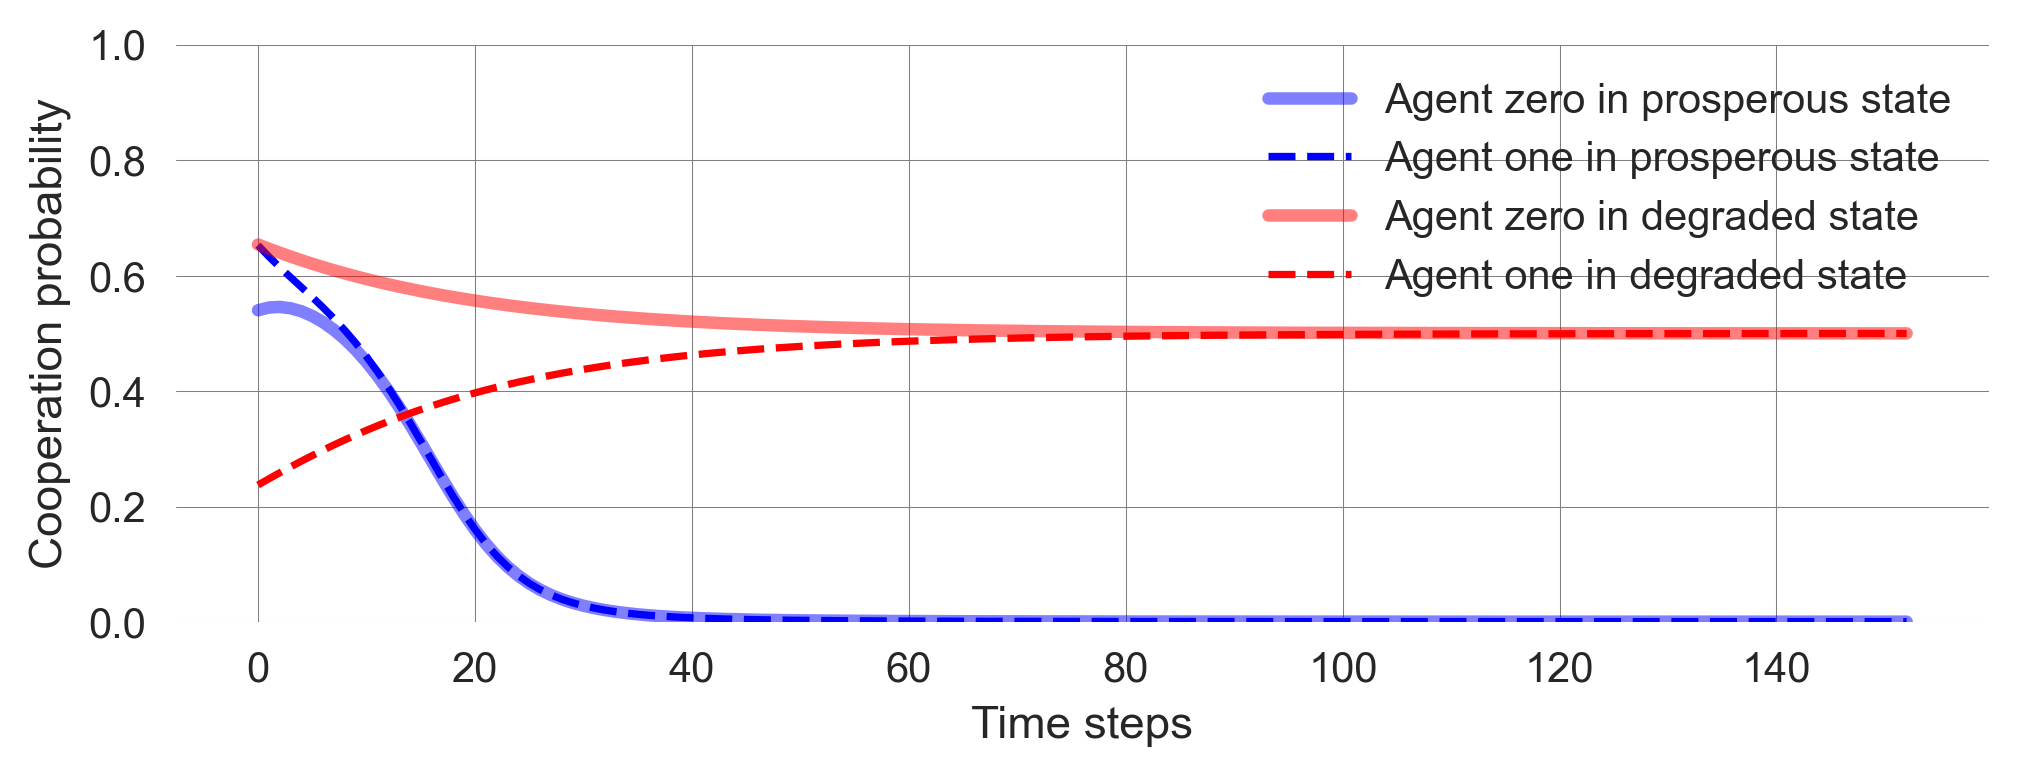

In [ ]:
c = env.Aset[0].index('c'); d = env.Aset[0].index('d')  # action indices
plt.plot(policy_trajectory_Xtisa[:, 0, p, c], label='Agent zero in prosperous state', c='blue', lw=3, alpha=0.5)
plt.plot(policy_trajectory_Xtisa[:, 1, p, c], label='Agent one in prosperous state', c='blue', ls='--')
plt.plot(policy_trajectory_Xtisa[:, 0, g, c], label='Agent zero in degraded state', c='red', lw=3, alpha=0.5)
plt.plot(policy_trajectory_Xtisa[:, 1, g, c], label='Agent one in degraded state', c='red', ls='--');
plt.xlabel('Time steps'); plt.ylabel('Cooperation probability'); plt.legend(); plt.ylim(0, 1);

Let's repeat this serveral times from different random joint policies. **Exectue the cell below multiple times and observe what happens**.

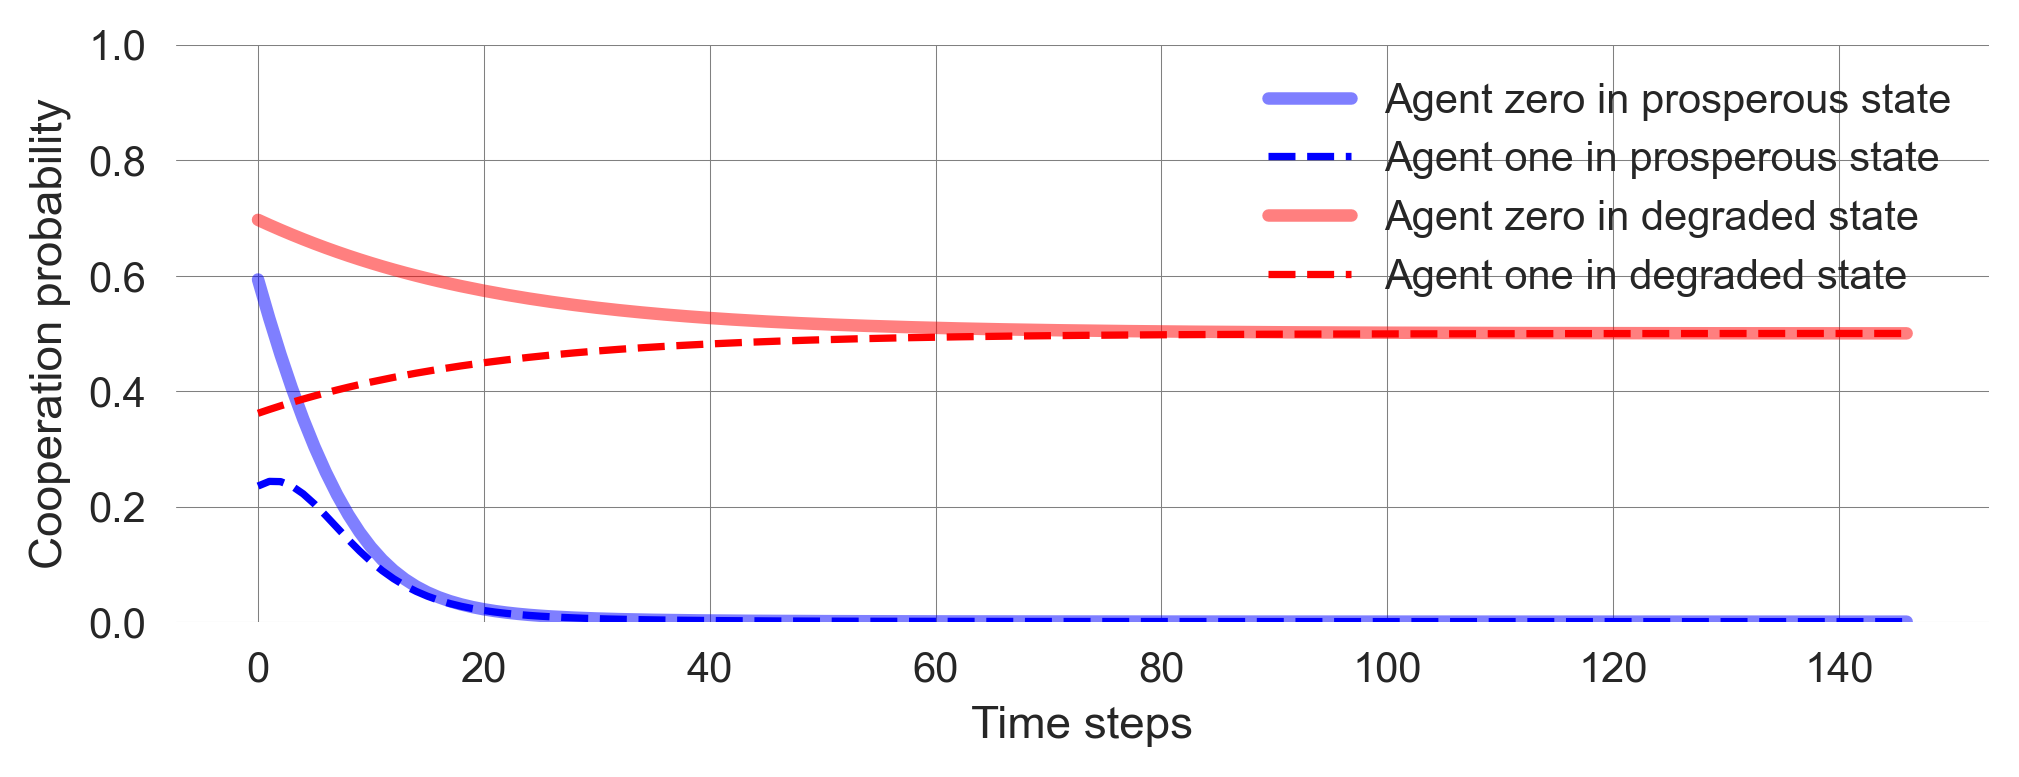

In [ ]:
x = MAEi.random_softmax_strategy()
policy_trajectory_Xtisa, fixedpointreached = MAEi.trajectory(x, Tmax=5000, tolerance=10**-5)

plt.plot(policy_trajectory_Xtisa[:, 0, p, c], label='Agent zero in prosperous state', c='blue', lw=3, alpha=0.5)
plt.plot(policy_trajectory_Xtisa[:, 1, p, c], label='Agent one in prosperous state', c='blue', ls='--')
plt.plot(policy_trajectory_Xtisa[:, 0, g, c], label='Agent zero in degraded state', c='red', lw=3, alpha=0.5)
plt.plot(policy_trajectory_Xtisa[:, 1, g, c], label='Agent one in degraded state', c='red', ls='--');
plt.xlabel('Time steps'); plt.ylabel('Cooperation probability'); plt.legend(); plt.ylim(0, 1);

**Some observations** you should make:

* **Learning occurs fast**. The agents quickly attain a stable state within just a few hundred steps, and their execution is remarkably rapid.
* **Learning is deterministic**. Given an initial joint policy, the learning process has no stochastic fluctuations. The agents learn deterministically. However, *what* they learn is a probability distribution.
* **Outcome is bistable**. The agents learn to either cooperate or defect completely in the prosperous state, depending on where they start. If they start closer to cooperation, they learn to cooperate. If they start closer to defection, they learn to defect. 
* **Agents randomize**. In the degraded state, agents learn to randomize over actions fully, i.e., choose each of their two options with a probability of 0.5. This is because the agents cannot influence the outcome of their actions and, thus, are driven only by exploration. You can imagine the desire to explore as a form of intrinsic motivation that dominates here without controllable extrinsic rewards.

### Flow plot

The determinism and the fast computation allow for an improved visualization of the learning process. As with any deterministic dynamic system, we can visualize the flow plot of the dynamics (See Chapter [02.01](02.01-Nonlinearity.ipynb)). 

In the `pyCRLD` package, we have a special module for that purpose.

In [ ]:
from pyCRLD.Utils import FlowPlot as fp

Applying this function yields a flow plot of the learning dynamics which highlights the bistability of the learning process in the prosperous state and the randomization in the degraded state.

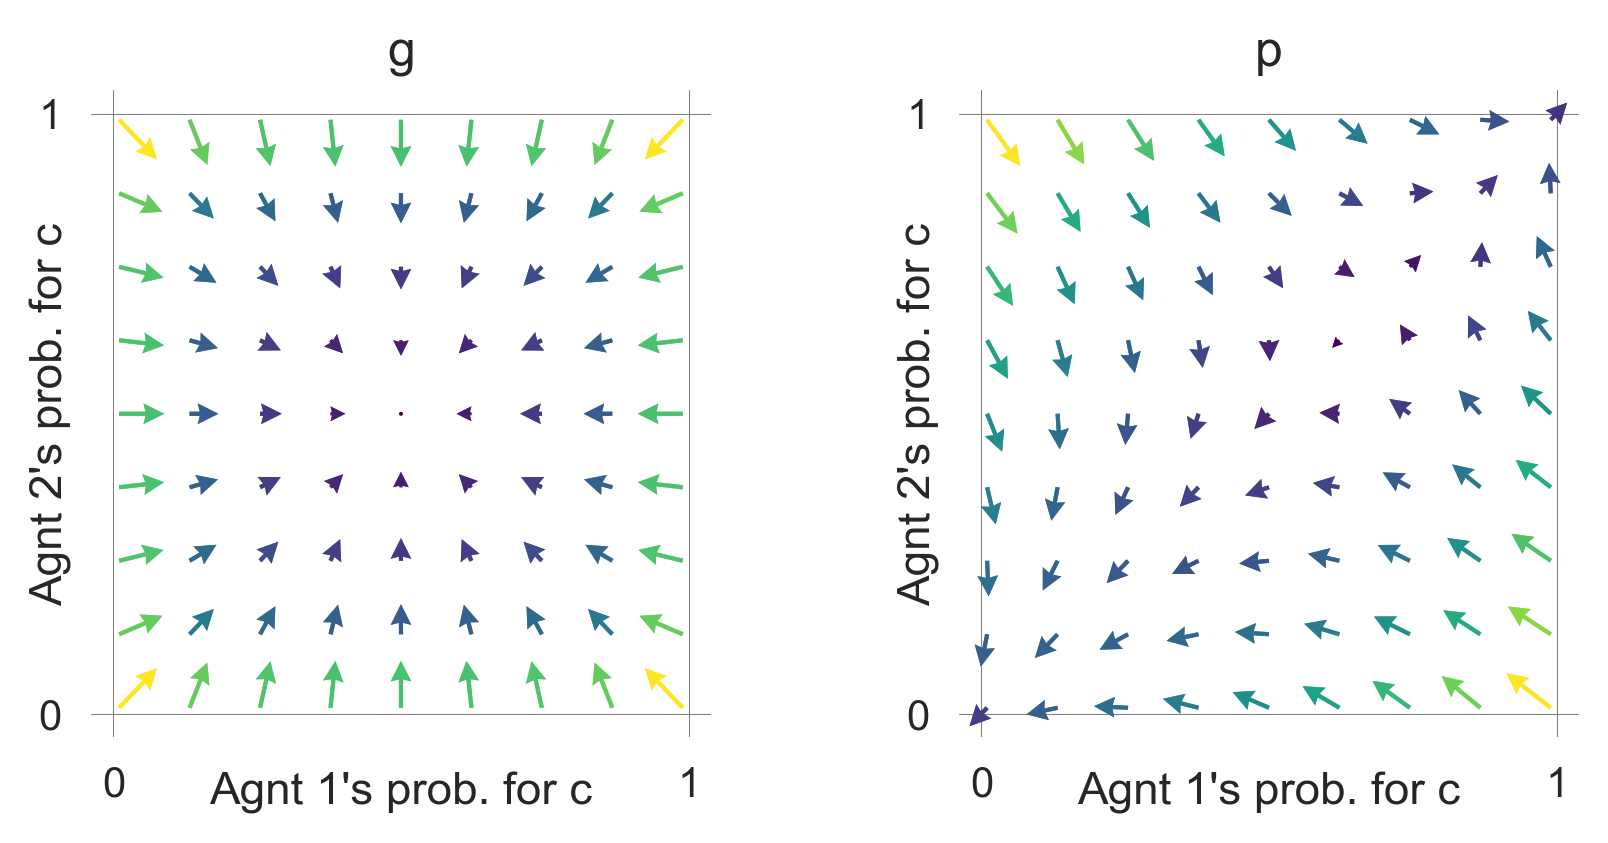

In [ ]:
#| fig-cap: "Basic flow of collective reinforcement learning dynamics."
x = ([0], [g,p], [c])  # which (agent, observation, action) to plot on x axis
y = ([1], [g,p], [c])  # which (agent, observation, action) to plot on y axis
eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
ax = fp.plot_strategy_flow(MAEi, x, y, action_probability_points, conds=env.Sset)

These flow plots allow for a geometric understanding of the collective learning dynamics over the whole joint policy space. In contrast to a standard flow plot, per default, the **arrows show the temporal-difference reward prediction error**. Thus, they have a cognitive interpretation. 

We may use them to study how the parameters of the learning agents and the environment influence the outcome.  

In [ ]:
def plot_flow(DiscountFactor=0.75, ChoiceIntensity=50, CollapseImpact=-5, CollapseLeverage=0.2):
    env = EcoPG(N=2, f=1.2, c=5, m=CollapseImpact, qc=CollapseLeverage,
                qr=0.01, degraded_choice=False)
    MAEi = stratSARSA(env, learning_rates=0.05, choice_intensities=ChoiceIntensity, 
                      discount_factors=DiscountFactor, use_prefactor=True)
    
    x = ([0], [g,p], [c])  # which (agent, observation, action) to plot on x axis
    y = ([1], [g,p], [c])  # which (agent, observation, action) to plot on y axis
    eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
    ax = fp.plot_strategy_flow(MAEi, x, y, action_probability_points, conds=env.Sset)

When working with this material in a Jupyter notebook, we can interactively study the parameter dependence of the flow plot.

::: {.content-hidden unless-profile="interactive"}

In [ ]:
interact(plot_flow, DiscountFactor=(0.1, 0.99, 0.01), ChoiceIntensity=(1, 100, 10), 
         CollapseImpact=(-10, 0, 0.5), CollapseLeverage=(0.01, 0.5, 0.01));

interactive(children=(FloatSlider(value=0.75, description='DiscountFactor', max=0.99, min=0.1, step=0.01), Int…

:::

For example, caring more for the future makes the cooperative basin of attraction larger.

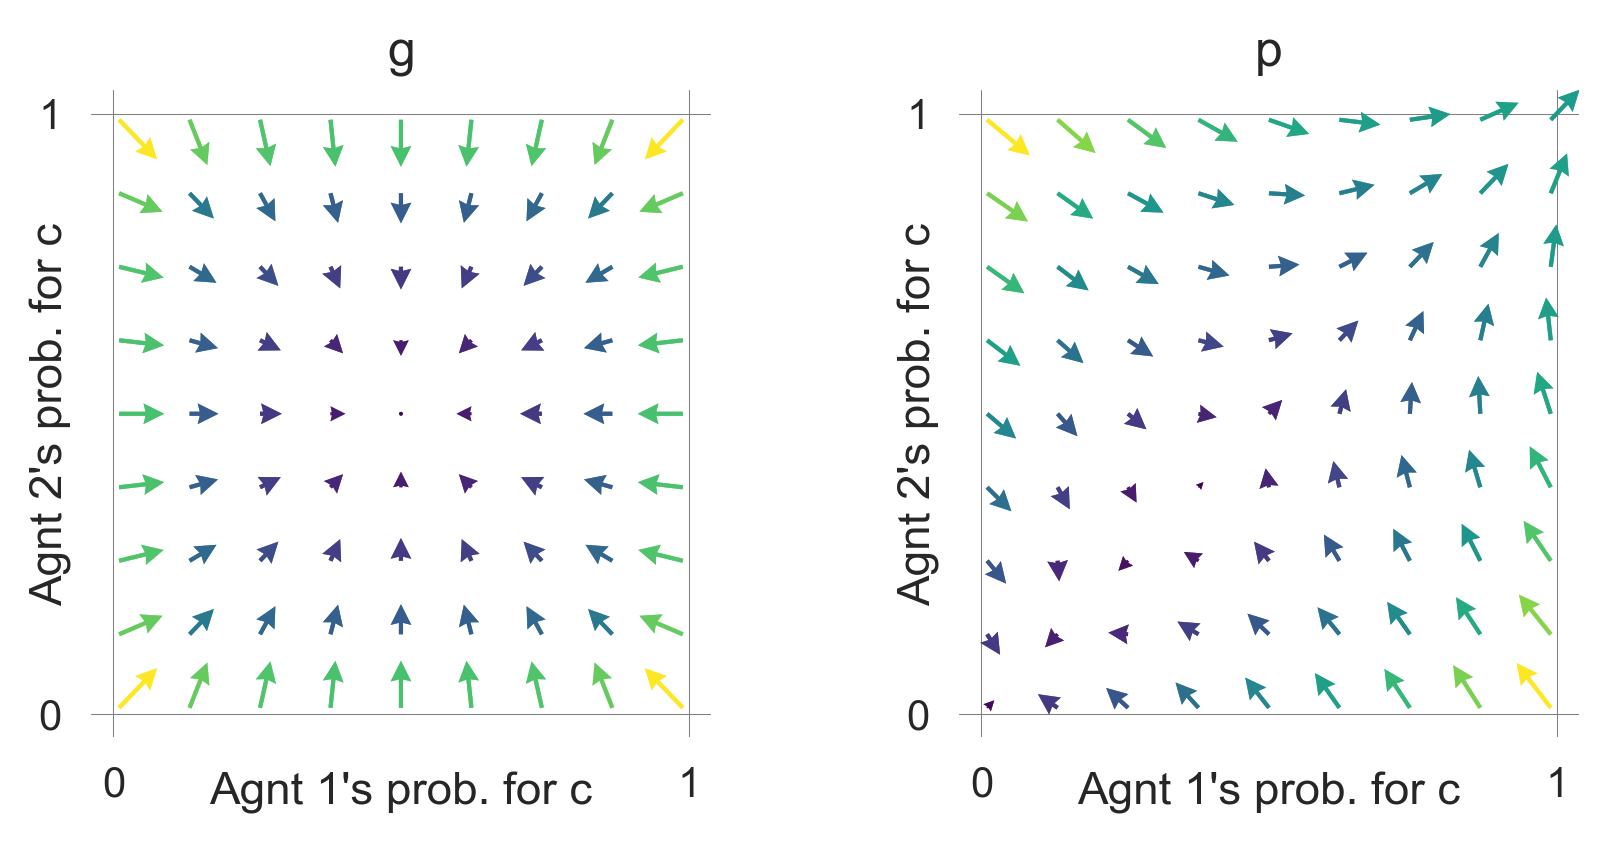

In [ ]:
#| fig-cap: "Learning flow with more future caring."
plot_flow(DiscountFactor=0.8)

So does a more severe collapse impact,

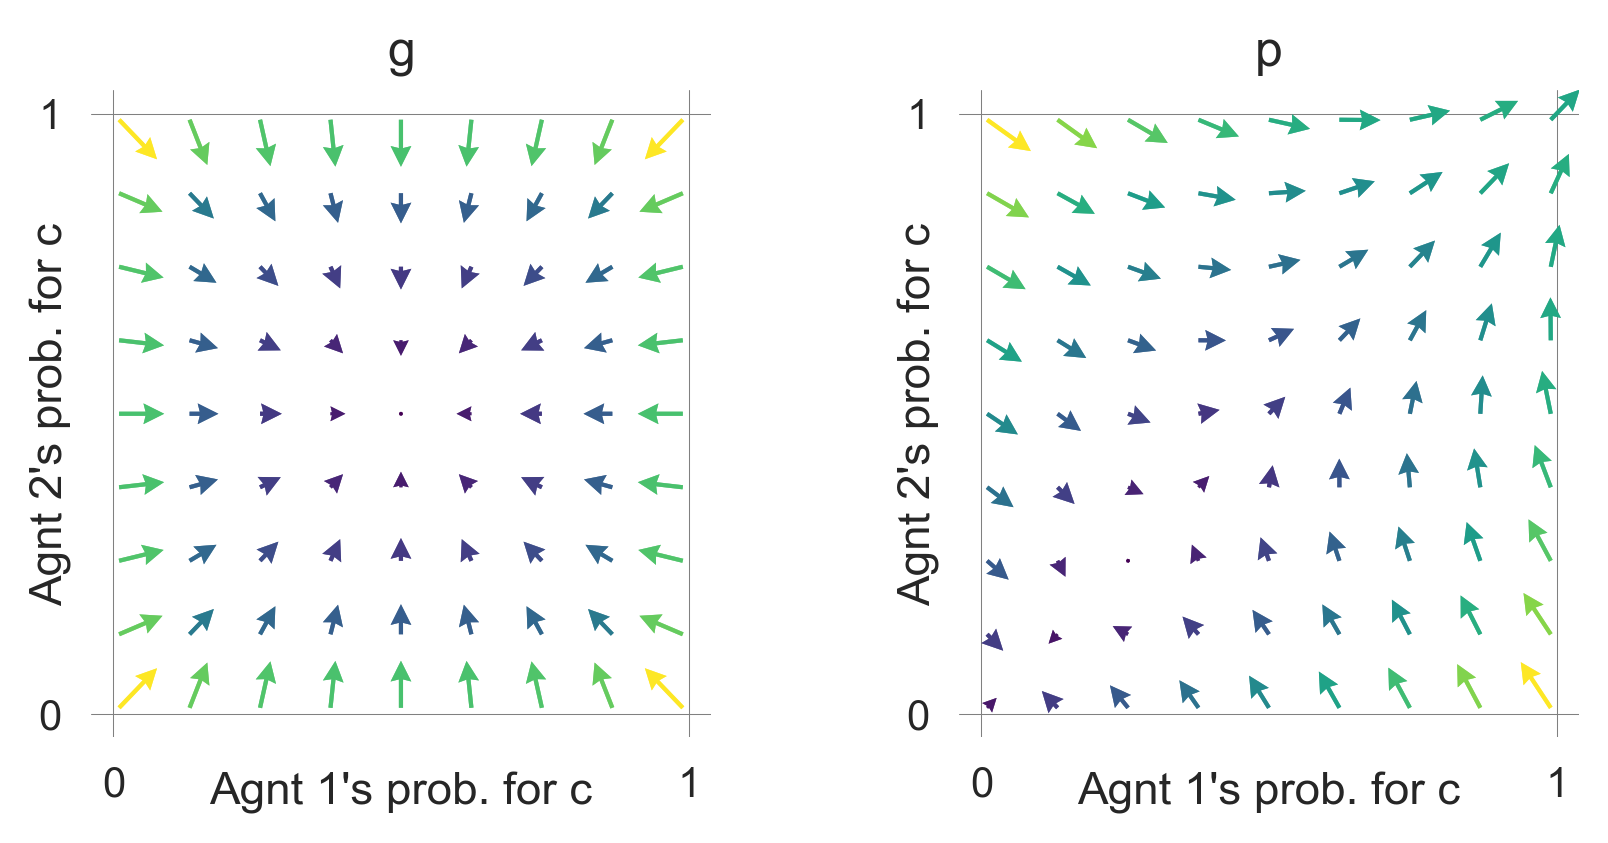

In [ ]:
#| fig-cap: "Learning flow with a more severe collapse impact."
plot_flow(CollapseImpact=-6)

and a collapse that occurse more likely or faster.

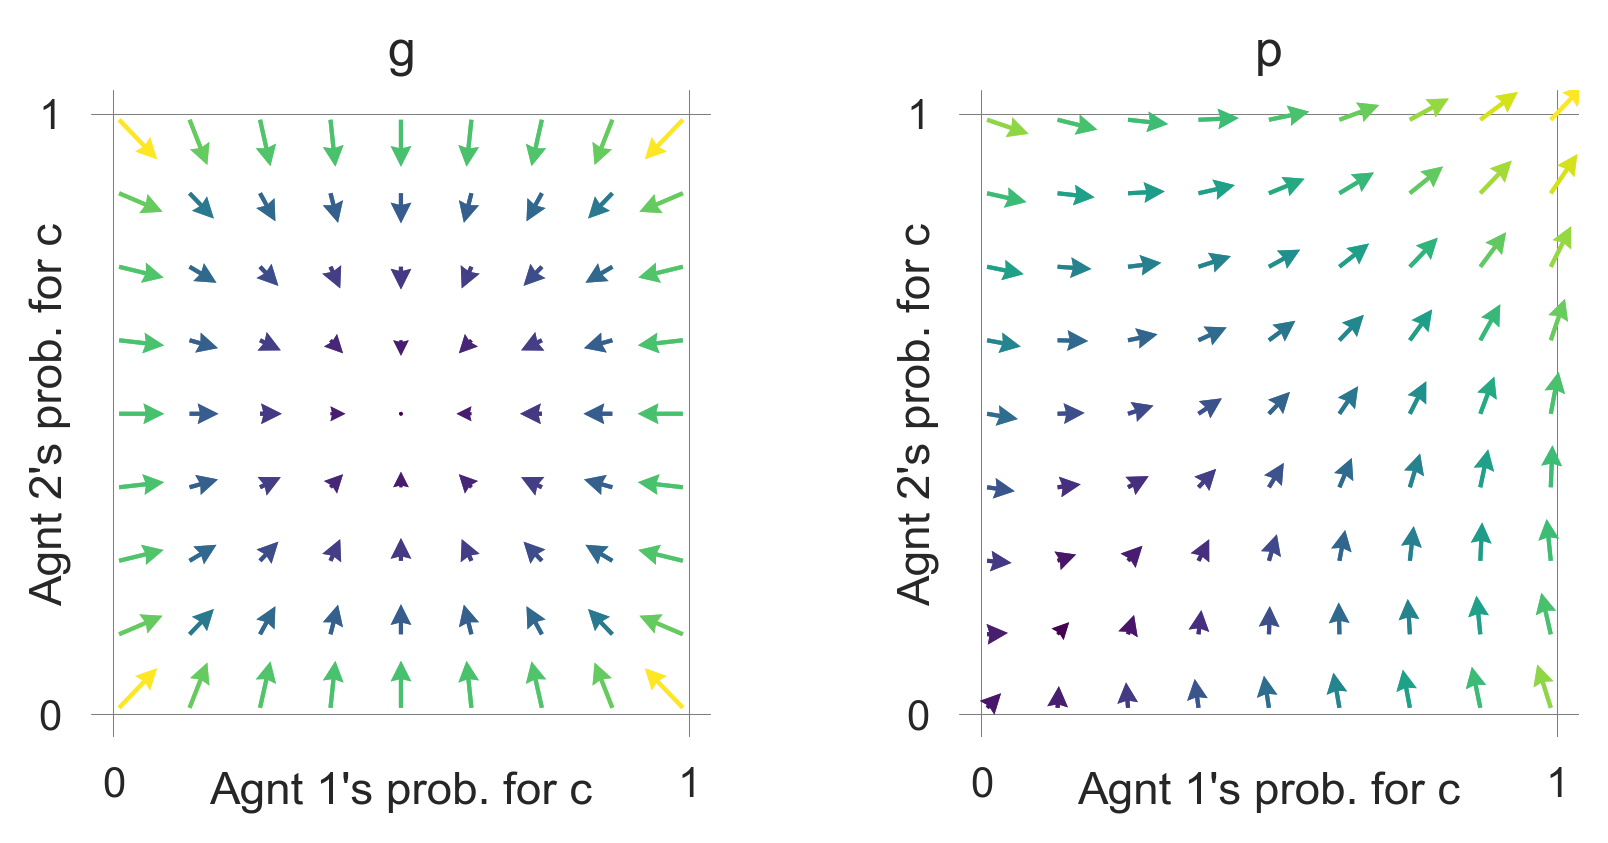

In [ ]:
#| fig-cap: "Learning flow with a higher collapse leverage."
plot_flow(CollapseLeverage=0.3)

The flow in the degraded state is unaffected by these parameter modulations.

A very low choice intensity makes the desire to explore (i.e., randomize) dominate also in the prosperous state.

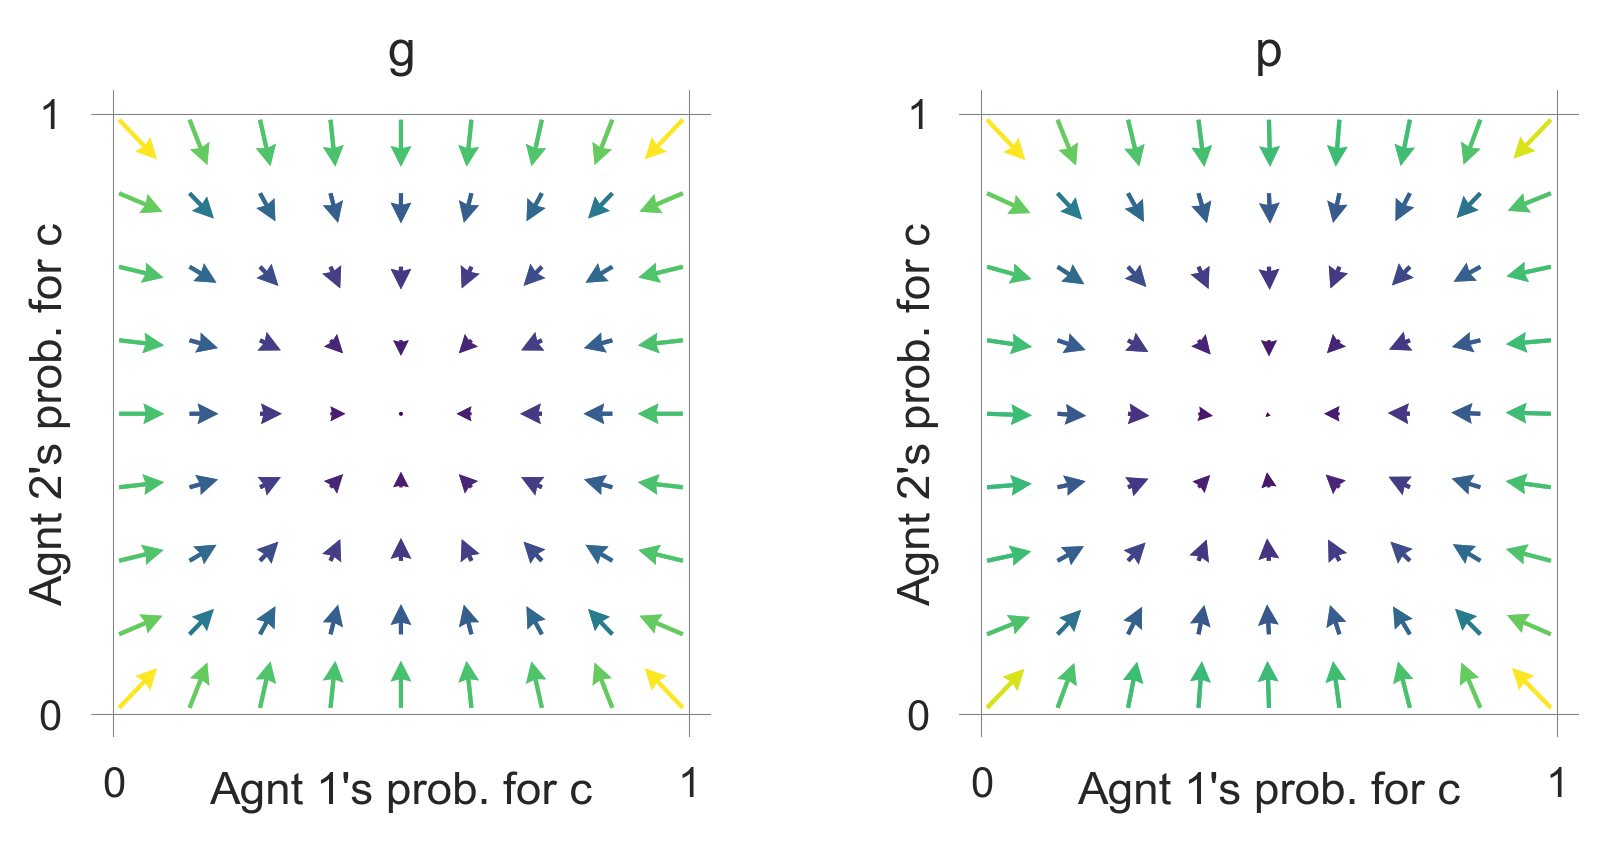

In [ ]:
#| fig-cap: "Learning flow with a small intensity of choice makes explorative behavior dominant."
plot_flow(ChoiceIntensity=1)

### Critical transition

Let us study the learning behavior around the separatrix of the bistable region.

First, we define a function that allows us to enter initial cooperation probabilities for both agents and return a proper joint policy. This function sets the cooperation probability in the degraded state to 0.5 for both agents, as we have seen that the agents will eventually learn to randomize in the degraded state and we are not interested in that part of the learning behavior.

In [ ]:
def compile_strategy(p0c:float,  # cooperation probability of agent zero
                     p1c:float):  # cooperation probability of agent one
    Pi = np.array([0.5, p0c])  # coop. prob. in the degraded state set to 0.5
    Pj = np.array([0.5, p1c])
    xi = np.array([Pi, 1-Pi]).T
    xj = np.array([Pj, 1-Pj]).T
    return np.array([xi, xj])              

We setup the multiagent-environment interaface.

In [ ]:
env = EcoPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)
MAEi = stratSARSA(env=env, learning_rates=0.01, choice_intensities=100, discount_factors=0.75,
                  use_prefactor=True)

To get a feeling for the critical transition, we create three well chosen learning trajectories.

In [ ]:
xtrajs = []  # storing strategy trajectories 
fprs = []    # and whether a fixed point is reached
for pc in [0.18, 0.19, 0.20]:  # cooperation probability of agent 1
    X = compile_strategy(pc, 0.95)
    xtraj, fixedpointreached = MAEi.trajectory(X, Tmax=5000, tolerance=10**-5)
    xtrajs.append(xtraj); fprs.append(fixedpointreached)
    print("Trajectory length:",len(xtraj))

Trajectory length: 178
Trajectory length: 234
Trajectory length: 174


We plot them ontop of the learning flow.

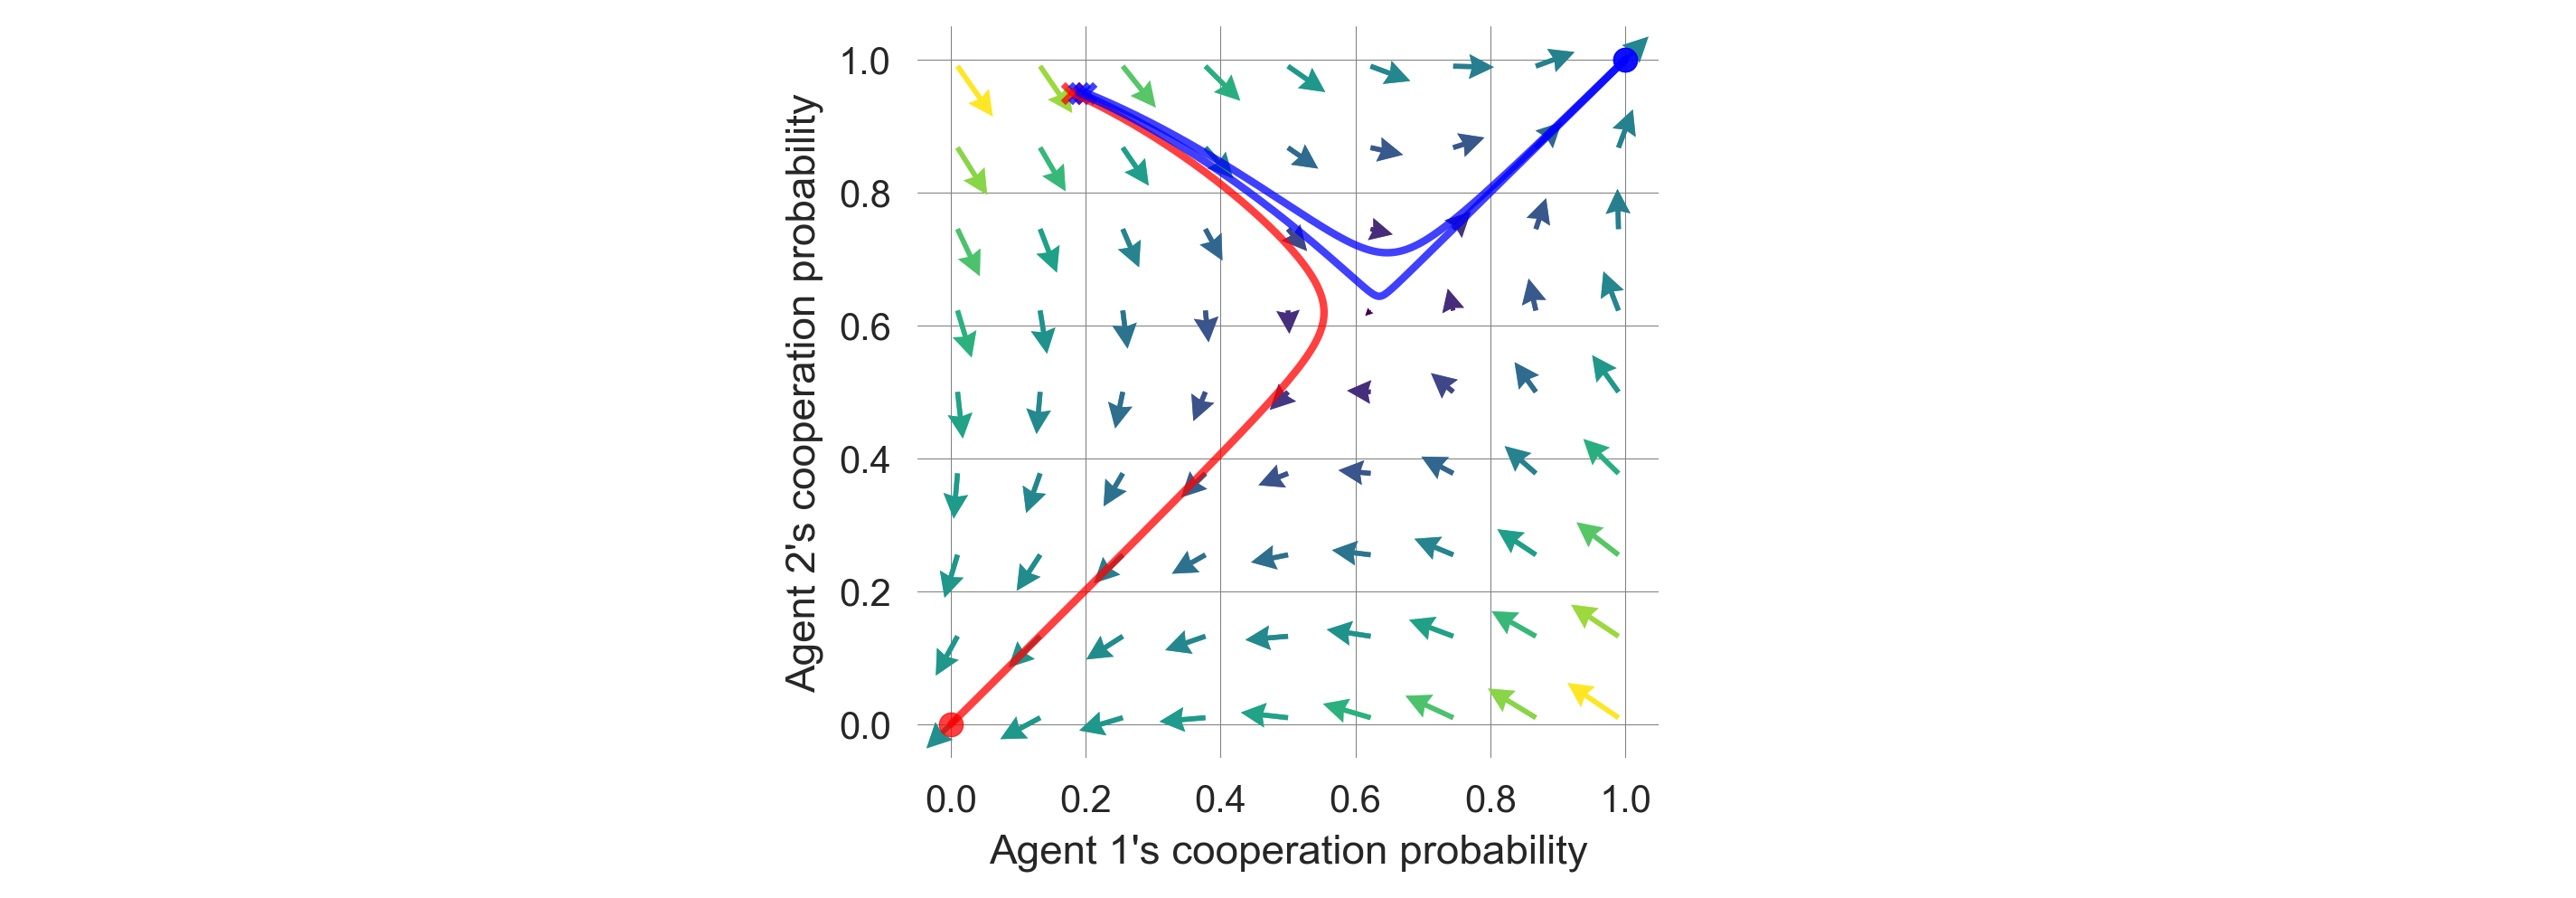

In [ ]:
fig = plt.figure(figsize=(12, 3.5)); ax = fig.add_subplot(132) # to center the plot
fig.add_subplot(131, xticks=[], yticks=[]); fig.add_subplot(133, xticks=[], yticks=[]);

x = ([0], [p], [c])  # which (agent, observation, action) to plot on x axis
y = ([1], [p], [c])  # which (agent, observation, action) to plot on y axis
eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
fp.plot_strategy_flow(MAEi, x, y, action_probability_points, axes=[ax])
   
# Add trajectories to flow plot
fp.plot_trajectories(xtrajs, x=x, y=y, fprs=fprs, cols=['red','blue','blue'],
                     lws=[2], msss=[2], lss=['-'], alphas=[0.75], axes=[ax]);

ax.set_ylabel("Agent 2's cooperation probability"); 
ax.set_xlabel("Agent 1's cooperation probability");

Next, we create a more fine-grained bundle of learning trajectories.

In [ ]:
# Cooperation probability of agent 1
pcs = np.concatenate([np.linspace(0.01, 0.99, 51), np.linspace(0.185, 0.195, 151)])
pcs = np.sort(np.unique(pcs))

Xktisa = []  # storing strategy trajectories 
fprs = []    # and whether a fixed point is reached
for i, pc in enumerate(pcs):
    print(f"Progress: {((i+1)/len(pcs)):.2%}", end="\r")
    X = compile_strategy(pc, 0.95)
    PolicyTrajectories_Xtisa, fixedpointreached = MAEi.trajectory(X, Tmax=5000, tolerance=10**-5)
    Xktisa.append(PolicyTrajectories_Xtisa)
    fprs.append(fixedpointreached)

Progress: 100.00%

**We obtain the critical point in this bundle of learning trajectories where the two agents switch or tip from complete defection to complete cooperation.**

First, we check that all trajectories converged.

In [ ]:
np.all(fprs)

True

Then, we obtain the cooperation probabilities at convergence.

In [ ]:
converged_pcs = np.array([Xtisa[-1][:, p, c] for Xtisa in Xktisa])
converged_pcs.shape

(201, 2)

Last, we show the biomodal distribution of full defection and full cooperation.

In [ ]:
np.histogram(np.array(converged_pcs).mean(-1), range=(0,1))[0]

array([ 80,   0,   0,   0,   0,   0,   0,   0,   0, 121])

Thus, the critical point lies at the index

In [ ]:
cp = np.histogram(np.array(converged_pcs).mean(-1), range=(0,1))[0][0]
cp

80

and has an approximate value between

In [ ]:
print(pcs[cp-1], 'and', pcs[cp], '.')

0.18966666666666668 and 0.18973333333333334 .



We use this more fine-grained bundle of learning trajectories to visualize the phenomenon of a **critical slowing down** by plotting the time steps required to reach convergence. 


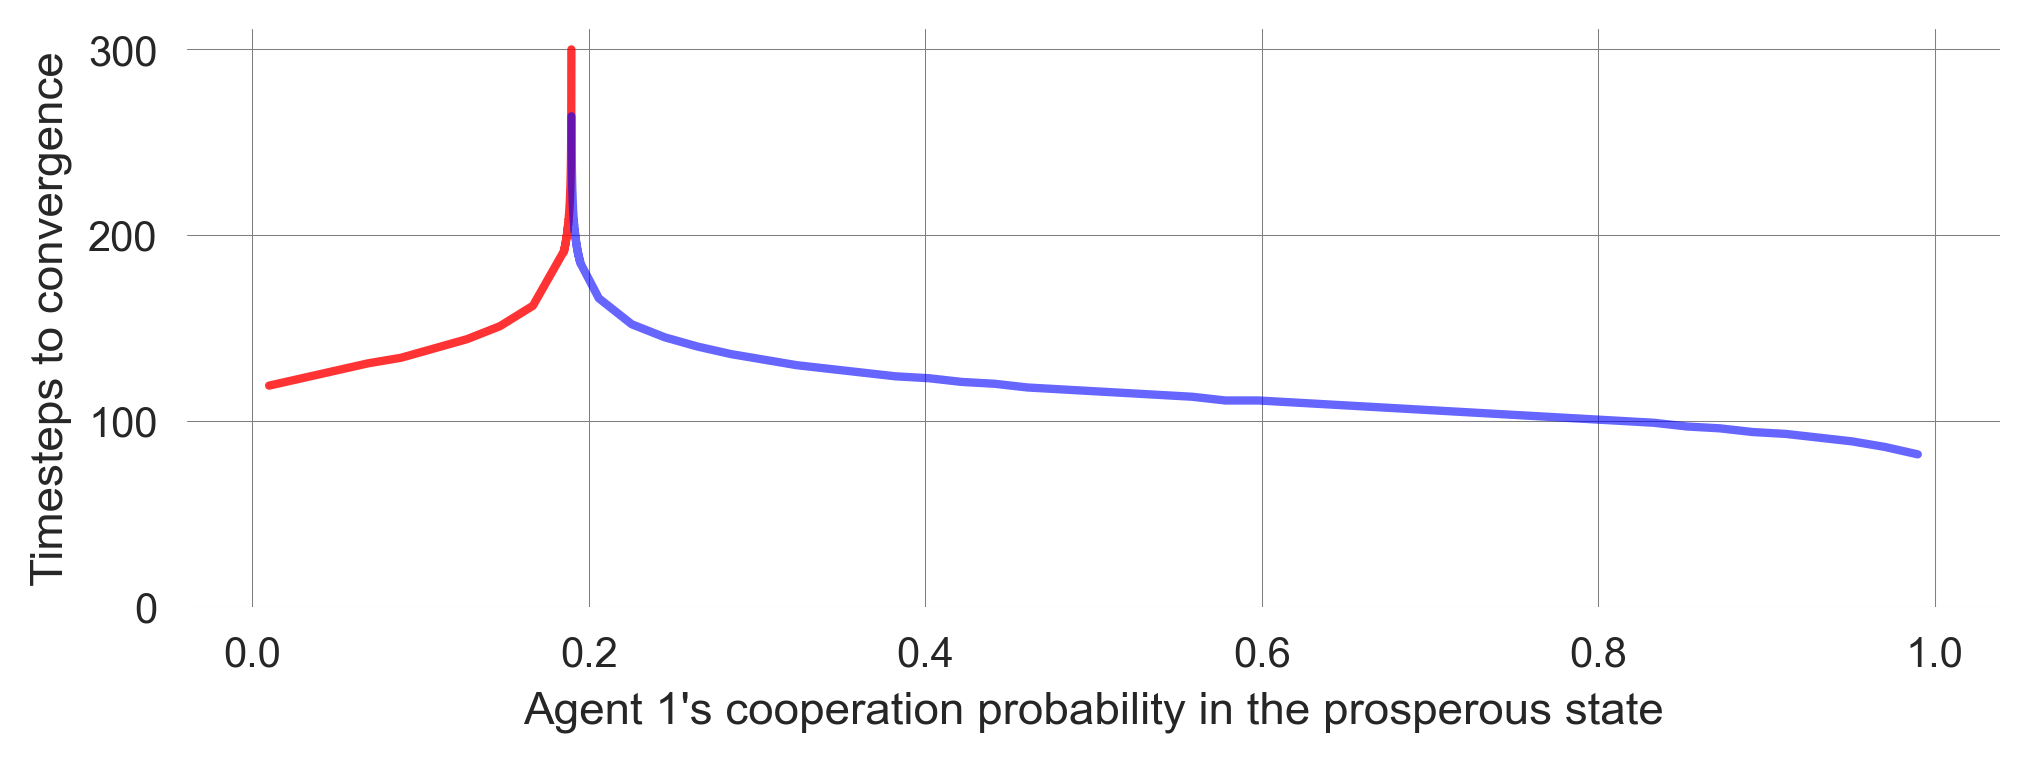

In [ ]:
#| fig-cap: "Time steps required to convergence show a critical slowing down around the tipping point."
plt.plot(pcs[:cp], [len(Xtisa) for Xtisa in Xktisa[:cp]],
         '-', color='red', lw=2, alpha=0.8)  # defectors in red
plt.plot(pcs[cp:], [len(Xtisa) for Xtisa in Xktisa[cp:]], 
         '-', color='blue', lw=2, alpha=0.6) # cooperators in blue
plt.ylim(0); plt.ylabel('Timesteps to convergence')
plt.xlabel(f"Agent 1's cooperation probability in the prosperous state");

We also observe a kind of **transient tipping point** in the learning dynamics, when plotting the two closest trajectories around the critical point.

In [ ]:
def plot_TransientTipping(xlim=None):
    # Plot the defecting learners in red
    plt.plot(Xktisa[cp-1][:, 0, p, c], color='red', lw=5, ls=':', label='Agent zero') 
    plt.plot(Xktisa[cp-1][:, 1, p, c], color='red', lw=4, ls="--", alpha=0.4, label='Agent one')
    
    # Plot the cooperating learners in blue
    plt.plot(Xktisa[cp][:, 0, p, c], color='blue', lw=3, ls=':', label='Agent zero')
    plt.plot(Xktisa[cp][:, 1, p, c], color='blue', lw=2, ls="--", alpha=0.4, label='Agent one')
    
    plt.xlim(xlim); plt.legend(); plt.xlabel("Timesteps"); plt.ylabel("Cooperation")

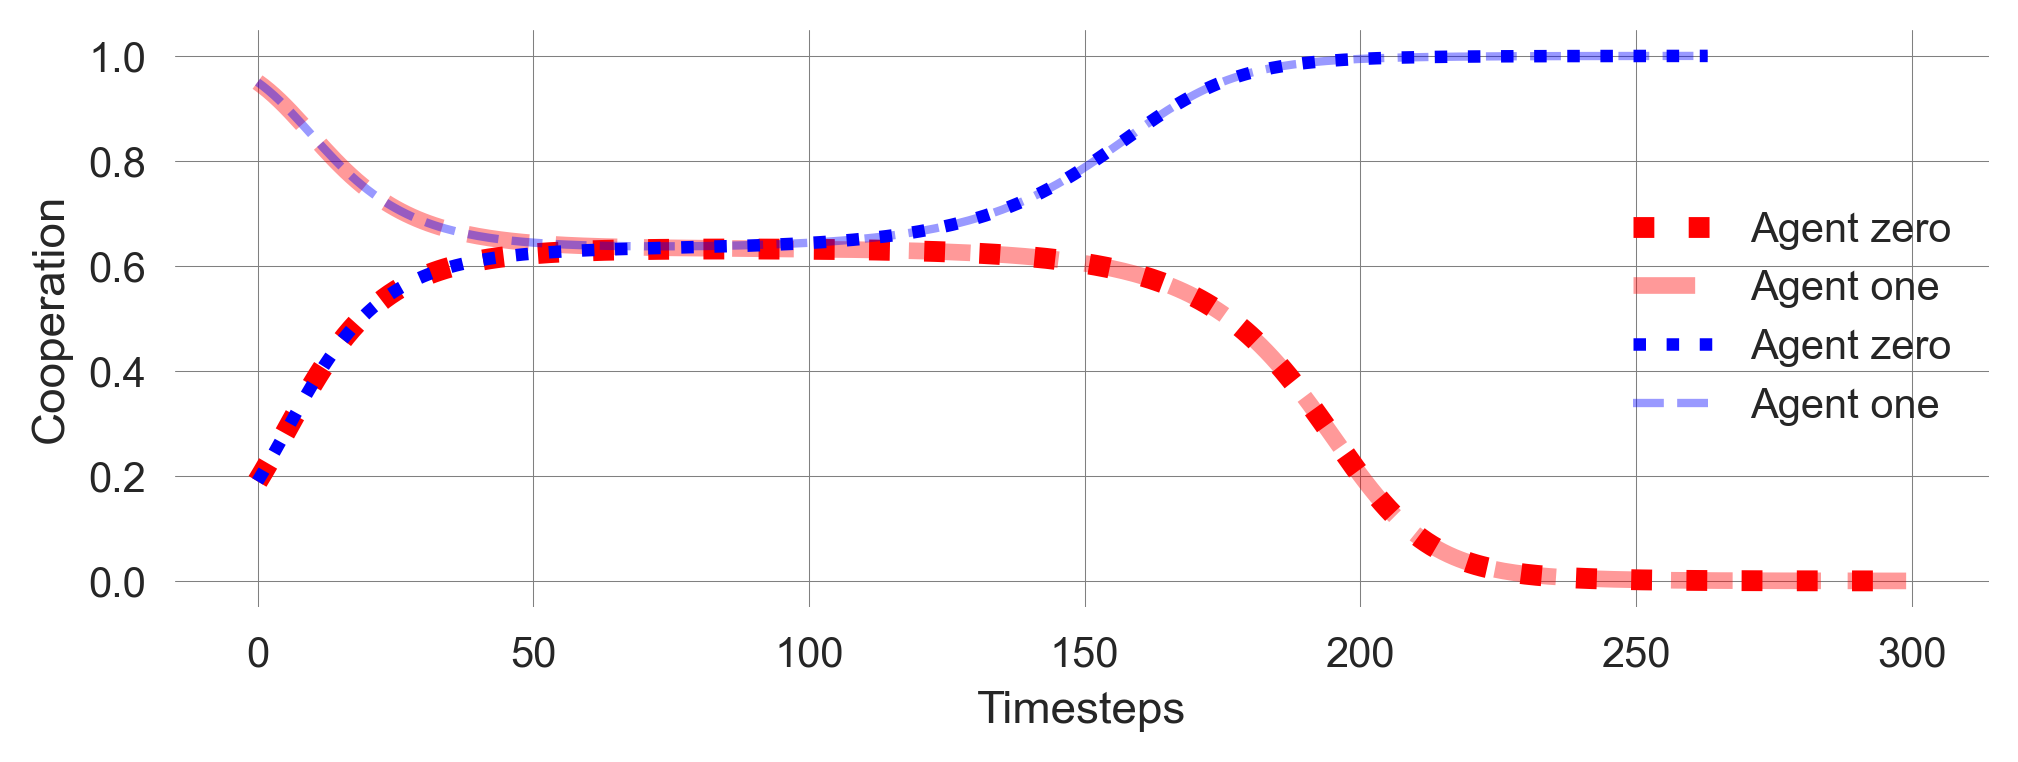

In [ ]:
#| fig-cap: "Emergent time scale seperation at the critical point."
plot_TransientTipping()

During this **emergent timescale separation**, the learning process seems to settle on a mixed policy after approximately 50 timesteps. It remains at this point for another 50 steps, which is the same duration it took to reach this mixed policy (@fig-apparent-convergence). The learning adjusts the policies more rapidly after this period until they converge to two deterministic policies.

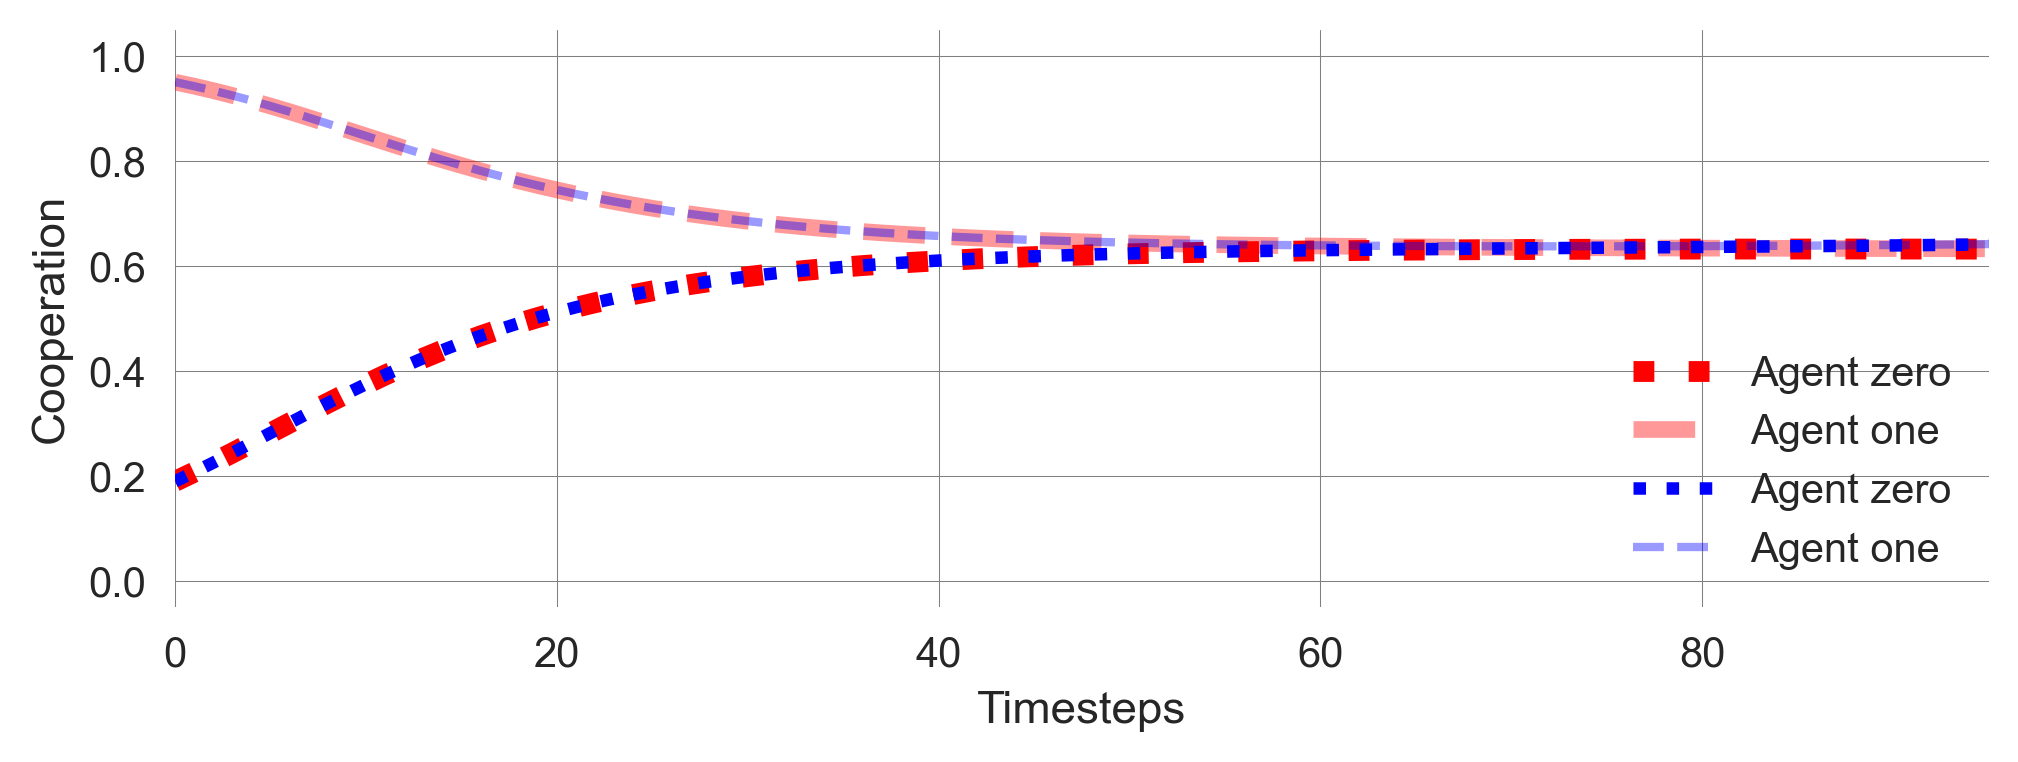

In [ ]:
#| fig-cap: "Apparent convergence to a mixed policy."
#| label: fig-apparent-convergence
plot_TransientTipping((0, 95))

### Hysteresis

The last phenomenon we want to highlight is hysteresis (See Chapter [02.02](02.02-TippingElements.ipynb)). We study the cooperation probabilities of the agents in the prosperous state as a function of the discount factor $\gamma$. We know from Chapter [03.03](03.03-DynamicInteractions.ipybn) that caring for the future can turn a tragedy of the commons into a comedy while passing through the coordination regime. 

In the following, we start at a relatively low level of caring for the future, increase it, and then decrease it again, all while letting the agent learn along

First, let us create the discount factor values.

In [ ]:
dcfs = list(np.arange(0.6, 0.9, 0.005))
hystcurve = dcfs + dcfs[::-1]

Then, we set up the environment and start the simulation from a random policy. We let the agents learn for 2500 time steps or until the learning process converges with a tiny tolerance. Then, we record the final policy, advance the discount factor, and restart from the previous final policy.

In [ ]:
# Set up the ecological public goods environment
env = EcoPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)

coops = []  # for storing the cooperation probabilities
X = MAEi.random_softmax_strategy() 
for i, dcf in enumerate(hystcurve):
    # Adjust multi-agent environment interface with discount factor
    MAEi = stratSARSA(env=env, discount_factors=dcf, use_prefactor=True,
                      learning_rates=0.05, choice_intensities=50)
    trj, fpr = MAEi.trajectory(X, Tmax=2500, tolerance=10e-12)
    print(f"Progress: {((i+1)/len(hystcurve)):6.2%} |",
          f"Discount Factor {dcf:5.4} | Conv?: {fpr}" , end="\r")        
    X = trj[-1] # select last strategy
    coops.append(X[:, 1, 0]) # append to storage container

Progress: 100.00% | Discount Factor   0.6 | Conv?: True


Now, we plot the computed data. We use the points' size and color to indicate the time dimensions of the discount factor changes. The time flows from big to small data points and from dark to light ones.

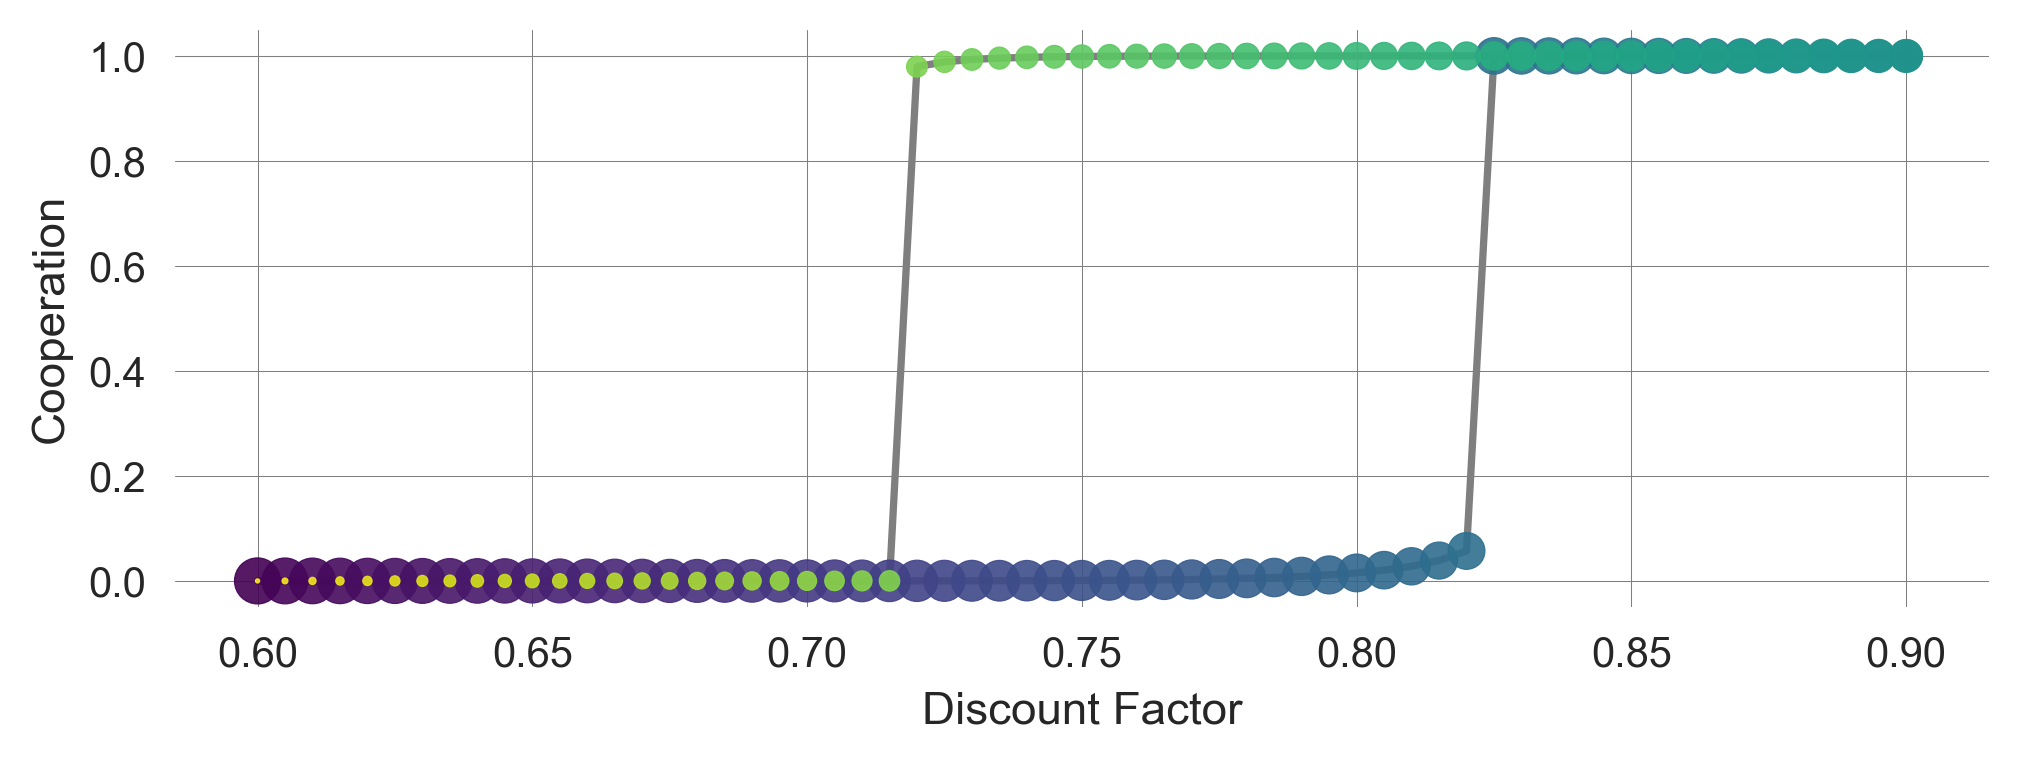

In [ ]:
#| fig-cap: "Hysteresis curve"
# Plot background line
plt.plot(hystcurve, np.array(coops).mean(-1),'-',alpha=0.5,color='k',zorder=-1)
# Plot data points with size and color indicating the time dimension
plt.scatter(hystcurve, np.array(coops).mean(-1), alpha=0.9, cmap='viridis',
            s=np.arange(len(hystcurve))[::-1]+1, c=np.arange(len(hystcurve)))

plt.ylabel('Cooperation'); plt.xlabel('Discount Factor'); #plt.ylim(0,1)


The hysteresis curve shows that the probability of cooperation among agents in the prosperous state depends on the history of the discount factor. The agents' learning dynamics exhibit a memory of the past, a typical feature of complex systems.

## Learning goals revisited

In this chapter,

- we introduced deterministic approximation models of the stochastic reinforcement learning process as a valuable tool for modeling complex human-environment interactions. Collective reinforcement learning dynamics model adaptive agents (in stylized model environments)
    - that use a perfect model of the world
    - in a computationally fast
    - transparent
    - and deterministically evolving way.
- We studied complex dynamic phenomena of multi-agent reinforcement learning in the ecological public good environment.
- To do so, we used the open-source `pyCRLD` Python package.


## Synthesis


**Collective reinforcement learning dynamics** bridge agent-based, equation-based (dynamic systems), and equilibrium-based modeling:

- agent-based: derived from individual agent characteristics
- equation-based: treated as a dynamical systems
- equilibrium-based: fixed points are (close to) the classic equilibrium solutions


![Three types of models](images/01.01-ThreeTypesOfModels.dio.png)


::: {.content-hidden unless-profile="standalone"}

## References

:::

::: {.content-hidden unless-profile="housekeeping"}

## Housekeeping

With the following cells, we can convert this notebook into slides and a PDF handout. If you work with this notebook interactively, you can ignore them.

---
metadata-files: [_standalone-quarto.yml]
---

In [ ]:
#| output: false 
!cp 04.03-LearningDynamics.ipynb 04.03-LearningDynamics_.ipynb
!quarto render 04.03-LearningDynamics_.ipynb --to pdf --profile standalone
!mv 04.03-LearningDynamics_.pdf __scripts/04.03-LearningDynamics.pdf
!rm -r 04.03-LearningDynamics_*

/Users/wolf/Other/miniconda3/envs/iw-dev/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


pandoc 
  to: latex
  output-file: 04.03-LearningDynamics_.tex
  standalone: true
  pdf-engine: xelatex
  variables:
    graphics: true
    tables: true
    secnumdepth: 2
  default-image-extension: pdf
  metadata-files:
    - _standalone-quarto.yml
  toc-depth: 2
  
metadata
  documentclass: scrartcl
  classoption:
    - DIV=11
    - numbers=noendperiod
  papersize: A4
  header-includes:
    - '\KOMAoption{captions}{tableheading}'
  block-headings: false
  title: Learning dynamics
  bibliography:
    - CSMofHEI.bib
  geometry:
    - top=20mm
    - left=20mm
    - right=20mm
    - bottom=25mm
  link-citations: true
  number-depth: 2
  

Rendering PDF
running xelatex - 1
  This is XeTeX, Version 3.14159265-2.6-0.999992 (TeX Live 2020) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode
  
running xelatex - 2
  This is XeTeX, Version 3.14159265-2.6-0.999992 (TeX Live 2020) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode


:::